In [1]:
# Import the libraries we'll use below.
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Import necessary librairies
import gc 
import numpy as np # linear algebra
from numpy import hstack
from numpy import array
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [3]:
import importlib
import utilities
importlib.reload(utilities)
from utilities import *

# Current plan
1. load the logerror targets
    - remove outliers such that the distribution is guassianish
2. load in the housing data
    - 

In [4]:
ZD = ZillowData()
data_with_logerr = ZD.get_data()
data_with_logerr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         53788 non-null   float64
 4   architecturalstyletypeid      468 non-null     float64
 5   basementsqft                  93 non-null      float64
 6   bathroomcnt                   167854 non-null  float64
 7   bedroomcnt                    167854 non-null  float64
 8   buildingclasstypeid           31 non-null      float64
 9   buildingqualitytypeid         107173 non-null  float64
 10  calculatedbathnbr             166056 non-null  float64
 11  decktypeid                    1272 non-null    float64
 12  finishedfloor1squarefeet      12893 non-null

Are there any duplicate rows in the data?

In [ ]:
idsUnique = len(housing[['parcelid', 'transactiondate']].value_counts())
idsTotal = housing.shape[0]
idsDupli = idsTotal - idsUnique
print(f"There are {housing.shape[0] - idsUnique} duplicate IDs and transaction dates for {housing.shape[0]} total entries")

There are 0 duplicate IDs and transaction dates for 167888 total entries


### logerror labels

<Axes: xlabel='logerror', ylabel='Count'>

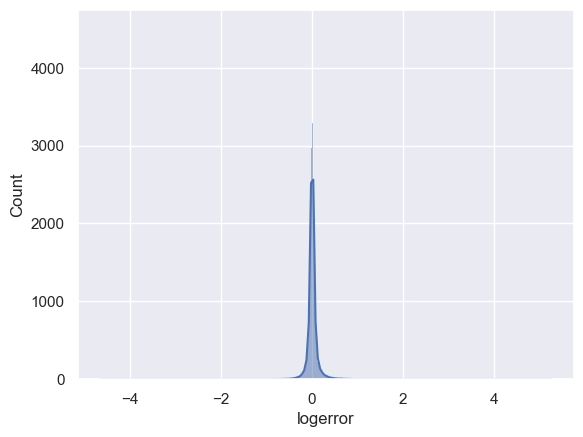

In [ ]:
sns.histplot(data=housing.logerror, kde=True)

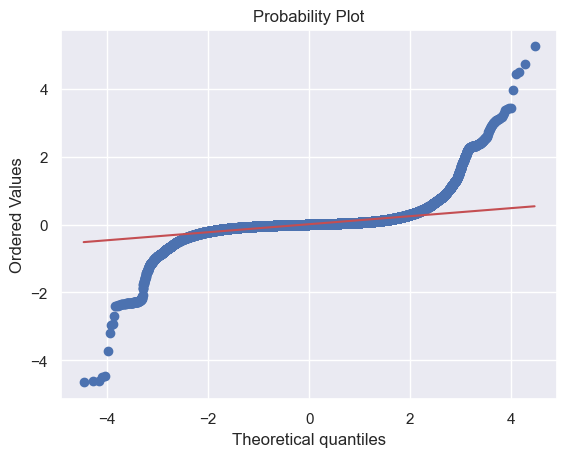

In [ ]:
#QQ-plot
fig = plt.figure()
res = stats.probplot(housing.logerror, plot=plt)
plt.show()

# drop outliers

In [ ]:
logerror_mean = housing.logerror.mean()
logerror_std = housing.logerror.std()
highest_thres = logerror_mean + 2.5  * logerror_std
lowest_thres = logerror_mean - 2.5 * logerror_std
print("Highest allowed",highest_thres)
print("Lowest allowed", lowest_thres)

Highest allowed 0.42817114871087447
Lowest allowed -0.4003585363683907


In [ ]:
# Only the training set outliers will be dropped (not validation or testing set to ensure model performs well on outliers too)
y = y[y > lowest_thres]
y = y[y < highest_thres]

# Update original Housing dataframe 
housing = housing[housing.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [ ]:
# Drop rows containing either 75% or more NaN Values
percent = 75.0 
min_count =  int(((100-percent)/100)*housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

In [ ]:
y.hist(bins=100, figsize=(8,5))
plt.show()

In [ ]:
#Check the new distribution 
sns.distplot(y , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split 
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    train_set = data.loc[~in_test_set]
    test_set = data.loc[in_test_set]
    
    X_train = train_set.drop("logerror", axis=1)
    y_train = train_set["logerror"].copy()
    X_test = test_set.drop("logerror", axis=1)
    y_test = test_set["logerror"].copy()
    return X_train, X_test, y_train, y_test

X_other, X_test, y_other, y_test = split_train_test_by_id(housing, 0.1, "parcelid")
print(f"Other Dataset Shape: {X_other.shape}; Test Dataset Shape: {X_test.shape}")

In [ ]:
# Split X_other into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, train_size=0.9, random_state=42)
print(f"Training Dataset Shape: {X_train.shape}")    # 81% of instances are in training 
print(f"Test Dataset Shape: {X_test.shape}")         # 10% of instances are in test 
print(f"Validation Dataset Shape: {X_val.shape}")    # 9% of instances are in validation

# Data preprocessing

In [ ]:
feature_na_ratio = (X_train.isnull().sum() / len(X_train)) * 100
feature_na_ratio = feature_na_ratio.drop(feature_na_ratio[feature_na_ratio == 0].index).sort_values(ascending=False)
feature_na_ratio_df = pd.DataFrame({'Missing Ratio' : feature_na_ratio})
feature_na_ratio_df

In [ ]:
feature_na_ratio_df[feature_na_ratio_df['Missing Ratio'] < 15]

In [ ]:
print ("Features with one unique value!!")
exclude_unique = []
for c in X_train.columns:
    num_uniques = len(X_train[c].unique())
    if X_train[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(c)
print(exclude_unique)

### Drop features
- `finishedsquarefeet13`: Data description says 'Perimeter Living Area'. Over 99% of the dataset is missing values.
- `finishedsquarefeet15`: Data description says 'Total area'. Over 96% of the dataset is missing values.
- `finishedfloor1squarefeet`: Over 92% of the dataset is missing values.
- `finishedsquarefeet50`: Over 92% of the dataset is missing values.
- `storytypeid`: Data description states 35 possible values for the Story Type. Over 99% of the dataset is missing values.
- `buildingclasstypeid`: With over 99.8% of the dataset missing, imputing won't contribute any new information.
- `architecturalstyletypeid`: Data description states 27 possible values. Over 99% of the dataset is missing values.
- `typeconstructiontypeid`: Data description states 18 possible values. Over 99% of the dataset is missing values.
- `finishedsquarefeet6`: Data description states 'Base unfinished and finished area'. However, with over 99% of data missing, feature is dropped.
- `numberofstories`: With over 77% of the missing values and no one value dominating the variable distribution, it is impractical to impute and introduce incorrect information.
- `rawcensustractandblock`, `censustractandblock`: With almost 58k unique values, these features are being dropped until further research can be done into incorporating information from them in the model algorithm.
- `assessmentyear`: Dropping as the variable has only one unique value in the dataset.
- `parcelid`, `transactiondate`: This variable is not available when trying to predict target variable logerror
`basementsqft`, `yardbuildingsqft26`: Dropping due to over 96% of data missing.

### Duplciate features
- `pooltypeid10`, `hashottuborspa`: Duplicate information is present in `pooltypeid2` feature.
- `pooltypeid7`: Data description states 'Pool without Hot Tub', duplicate information is present in `pooltypeid2` feature which is boolean for 'Pool with Spa/Hot Tub'
- `fireplaceflag`: Duplicate information is present in `fireplacecnt` feature with `fireplaceflag` having a higher missing ratio.
- `threequarterbathnbr`, `calculatedbathnbr`, `fullbathcnt`: Duplicate information is present in bathroomcnt which has a lower missing ratio
- `finishedsquarefeet12`: Duplicate information in `calculatedfinishedsquarefeet`.
- `taxvaluedollarcnt`: Duplicate information from the sum of `structuretaxvaluedollarcnt` and `landtaxvaluedollarcnt`
- `roomcnt`: Duplicate information from `bedroomcnt` and `roomcnt` shows inconsistent data with majority of properties having 0 rooms in the principal residence
- `propertyzoningdesc`, `propertycountylandusecode`: `propertylandusetypeid` already provides similar information. In addition, this variable has over 2300 unique values - drastically increasing dataset cardinality.
- `regionidneighborhood`, `regionidzip`, `regionidcity`: With over 60% of the dataset missing values and 500+ unique values, there are better region based features such as `regionidcounty`, `latitude`, `longitude` to obtain this information
- `taxdelinquencyyear`: Given the high proportion of missing data (over 97%) and `taxdelinquencyflag` providing similar information, the information gain from years is low.

In [ ]:
cols_to_drop = [
    'parcelid',
    'transactiondate', #
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedfloor1squarefeet',
    'finishedsquarefeet50',
    'storytypeid',
    'buildingclasstypeid',
    'architecturalstyletypeid',
    'typeconstructiontypeid',
    'finishedsquarefeet6',
    'numberofstories',
    'rawcensustractandblock',
    'censustractandblock',
    'assessmentyear',
    'basementsqft',
    'yardbuildingsqft26',
    # duplcates
    'pooltypeid10',
    'hashottuborspa',
    'pooltypeid7',
    'fireplaceflag',
    'threequarterbathnbr',
    'calculatedbathnbr',
    'fullbathcnt',
    'finishedsquarefeet12',
    'taxvaluedollarcnt',
    'roomcnt',
    'propertyzoningdesc',
    'propertycountylandusecode',
    'propertylandusetypeid',
    'regionidneighborhood',
    'regionidzip',
    'regionidcity',
    'taxdelinquencyyear',
    # single value
    # 'decktypeid',
    # 'hashottuborspa',
    # 'poolcnt',
    # 'pooltypeid10',
    # 'pooltypeid2',
    # 'pooltypeid7',
    # 'storytypeid',
    # 'fireplaceflag',
    # 'taxdelinquencyflag',
]

In [ ]:
X_train_reduced = X_train.drop(cols_to_drop, axis=1)
X_train_reduced.info()

In [ ]:
reduced_feature_na_ratio = (X_train_reduced.isnull().sum() / len(X_train_reduced)) * 100
reduced_feature_na_ratio = reduced_feature_na_ratio.drop(reduced_feature_na_ratio[reduced_feature_na_ratio == 0].index).sort_values(ascending=False)
reduced_feature_na_ratio_df = pd.DataFrame({'Missing Ratio' : reduced_feature_na_ratio})
reduced_feature_na_ratio_df

In [ ]:
#Correlation map to see how features are correlated with SalePrice
corrmat = X_train_reduced.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
X_train_reduced = X_train_reduced.drop(['taxamount'], axis=1)
X_train_reduced.info()